# IM970 DataScience

## Mikro-Projekt: "Titanic"

[quelle: siehe KW51](http://jbusse.de/2019_ws_dsci/im970-termine.html)

### Aufgabe

Vorhersage ob ein Passagier überleben wird, oder nicht. 

## Abgabe

Aufgabe: Notebook Teil 2: "Codieren"  
Student: Michael Sachsenhauser, **Mat.Nr. 1042320**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
import pandas as pd
import math

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [4]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [5]:
# from sklearn.decomposition import PCA

## Business Understanding

### Determine Business Objectives

#### Background and Business Objectives:

Fragestellung: **"Kann anhand der Passagierdaten (socialStatus, age, gender) vorhergesagt werden, welche Überlebenschancen (Ja/Nein) ein Passagier hat?"**

#### Business success criteria

Das Ziel ist erreicht, wenn die Klassifikationsgenauigkeit ("accuracy") > 0.95 erreicht.

### Assess Situation

#### Inventory of Resources

*data*:

```
The titanic dataset gives the values of four categorical attributes for each of the 2201 people on board the Titanic when it struck an iceberg and sank. The attributes are social class (first class, second class, third class, crewmember), age (adult or child), sex, and whether or not the person survived. More information is available in the dtailed information.
```
[dataset information](https://www.cs.toronto.edu/~delve/data/titanic/titanicDetail.html)

*software*:

- python==3.7.4
  - sklearn==0.21.3
  - seaborn==0.9.0
  - matplotlib==3.1.1

*data scientist*: M.S.

#### Requirements, Assumptions, and Constraints

schedule of completion: '2020.01.15 15:56'  
comprehensibility and quality of results: error in accuracy
security: none  
legal issues: *be aware to not plagiate*

```
Dataset - INFO:
Converted for use in DELVE by Radford Neal, June 1996.
Originally compiled by Robert Dawson, 1995. 
```

**Assumption I:** Die Überlebenschance lässt sich indirekt über Geschlecht, Alter und sozialen Status ableiten.

#### Risks and Contingencies

*None*

#### Terminology

*None*

#### Costs and Benefits

*None*

### Determine Data Mining Goals

*Kein datamining Projekt*

### Produce project plan

*Kein Projektplan nötig, da es sich um ein "Mini-Projekt" handelt.*

## Data understanding

### Collect Initial Data

Create initial data collection report

Daten lokal unter: './data/*.csv', [Quelle:](https://moodle.haw-landshut.de/mod/resource/view.php?id=159912)

```
The attributes are social class (first class, second class, third class, crewmember), age (adult or child), sex, and whether or not the person survived.
```


In [6]:
X_train_orig = pd.read_csv("./data/titanic_delve_X_train.csv", index_col="Unnamed: 0")
y_train_orig = pd.read_csv("./data/titanic_delve_y_train.csv", index_col="Unnamed: 0")
X_train = X_train_orig.copy()
y_train = y_train_orig.copy()
df_train = pd.concat([X_train, y_train], axis=1)
print(df_train.shape)

(1474, 4)


In [7]:
X_test_orig = pd.read_csv("./data/titanic_delve_X_test.csv", index_col="Unnamed: 0")
y_test_orig = pd.read_csv("./data/titanic_delve_y_test.csv", index_col="Unnamed: 0")
X_test = X_test_orig.copy()
y_test_orig = y_test_orig.iloc[0:-2, :]
y_test_orig = y_test_orig.rename(columns={"0":"survived"})
y_test = y_test_orig.copy()

df_test = pd.concat([X_test, y_test], axis=1)
df_test = df_test.rename(columns={"0":"survived"})
print(df_test.shape)

(727, 4)


In [8]:
df_orig = pd.concat([df_train, df_test], sort=False)
print(df_orig.shape)
df = df_orig.copy()

(2201, 4)


### Describe Data

[Quelle Datenbeschreibung](https://www.cs.toronto.edu/~delve/data/titanic/desc.html)

Features:

- socialStatus: first class, second class, third class, crewmember
- age: ~~adult, child~~, actual age in years
- sex: male, female
- survived: yes / no

In [9]:
df.head()

socialStatus  age  gender survived
334          crew   41    male       no
1952          3rd   32  female       no
2175          3rd   45    male       no
1247          3rd   15    male       no
963          crew   48    male       no

In [10]:
# überprüfen, ob alle "id"s unique() sind 
# ... ggf. wäre Fehler bereits bei pd.read_ aufgetreten
len(df.index.unique())  # == 2201

2201

In [11]:
df.info(verbose=True);

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2201 entries, 334 to 1029
Data columns (total 4 columns):
socialStatus    2201 non-null object
age             2201 non-null int64
gender          2179 non-null object
survived        2201 non-null object
dtypes: int64(1), object(3)
memory usage: 86.0+ KB


In [12]:
df.describe()

age
count  2201.000000
mean     35.828714
std      20.110359
min       0.000000
25%      22.000000
50%      32.000000
75%      45.000000
max     106.000000

### Verify Data Quality

*vorgezogen um ggf. Nan's herauszufilter

In [13]:
df.isna().any()

socialStatus    False
age             False
gender           True
survived        False
dtype: bool

In [14]:
df[(df['gender'] != 'male') & (df['gender'] != 'female')].shape

(22, 4)

In [15]:
df[df['gender'].isna()].shape

(22, 4)

### Describe Data

 Features **Ausreißer** enthalten.

Verteilungen (visuell ermittelt) der einzelnen Features:

- socialStatus: first class, second class, third class, crewmember (*kategorisch*)
  - #crew: 885	#3rd: 706	#1st: 325	#2nd: 285
- age: ~~adult, child~~, actual age in years (*numerisch*)
  - mean: 35.83, std: 20.11 [total]
  - mean: 35.52, std: 19.63 [< 100]
- sex: male, female (*kategorisch*)
  - #male: 1711	#female: 468
- survived: yes / no (*kategorisch*)
  - #no: 1490	#yes: 711

*Informationen auch aus: Explore data*

### Explore Data

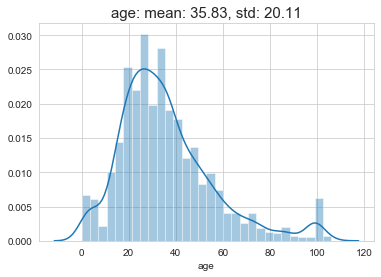

In [16]:
# verwende nur Zeilen, wo Weigth != nan
for col in ['age']:
    sns.distplot(df[~df[col].isna()][col]);
    plt.title(
        "{}: mean: {:.2f}, std: {:.2f}".format(
            col,
            df[~df[col].isna()][col].mean(),
            df[~df[col].isna()][col].std()
        ),
        size=15
    );
    plt.show()

**age:** scheint Ausreißer bei >= 100 zu haben. **> 100 nicht plausibel!**

In [17]:
df[df['age'] < 100].describe()

age
count  2191.000000
mean     35.520767
std      19.631035
min       0.000000
25%      22.000000
50%      32.000000
75%      45.000000
max      99.000000

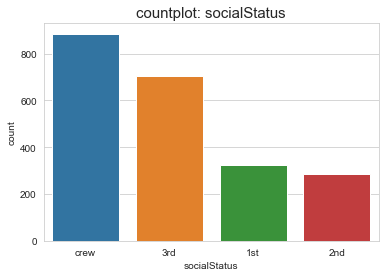

socialStatus:	#crew: 885	#3rd: 706	#1st: 325	#2nd: 285	
gender:	#male: 1711	#female: 468	#nan: 0	
survived:	#no: 1490	#yes: 711	


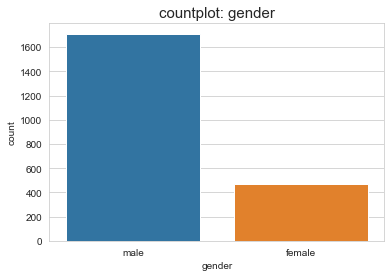

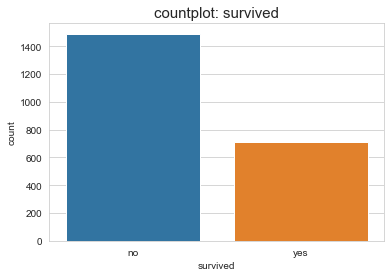

In [18]:
for col in [col for col in df.columns if col != 'age']:
    sns.countplot(x=col, data=df);
    plt.title("countplot: {}".format(col), size=15);
    plt.show();
    txt = "{}:\t".format(col)
    for val in df[col].unique():
        txt = "{}#{}: {}\t".format(
            txt,
            val,
            df[df[col] == val][col].count()
        )
    print(txt);

In [19]:
label_encoders = {}
for col in [col for col in df.columns if col != 'age']: 
    le = LabelEncoder()
    le.fit(df[df[col].notna()][col])
    print("{}: classes: {}".format(col, le.classes_))
    label_encoders[col] = le

socialStatus: classes: ['1st' '2nd' '3rd' 'crew']
gender: classes: ['female' 'male']
survived: classes: ['no' 'yes']


In [20]:
# create encoded dataframe
df_enc = df.copy()
for col in [col for col in df.columns if col != 'age']:
    df_enc.loc[df_enc[df_enc[col].notna()].index, col] = \
        label_encoders[col].transform(df[df[col].notna()][col])

C:\Users\sachs\.conda\envs\datascience\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\sachs\.conda\envs\datascience\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


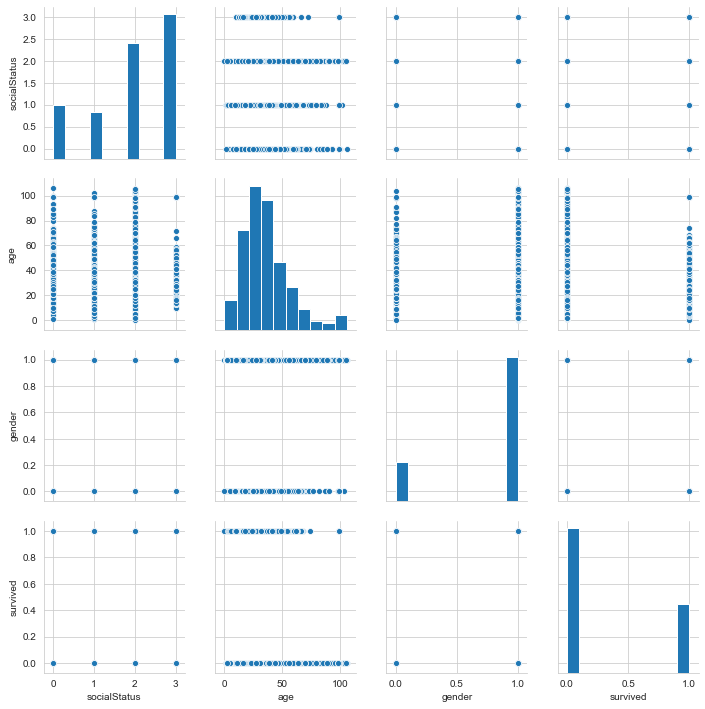

In [21]:
sns.pairplot(
    df_enc[df_enc.notna()]
);

C:\Users\sachs\.conda\envs\datascience\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\sachs\.conda\envs\datascience\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\sachs\.conda\envs\datascience\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\sachs\.conda\envs\datascience\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


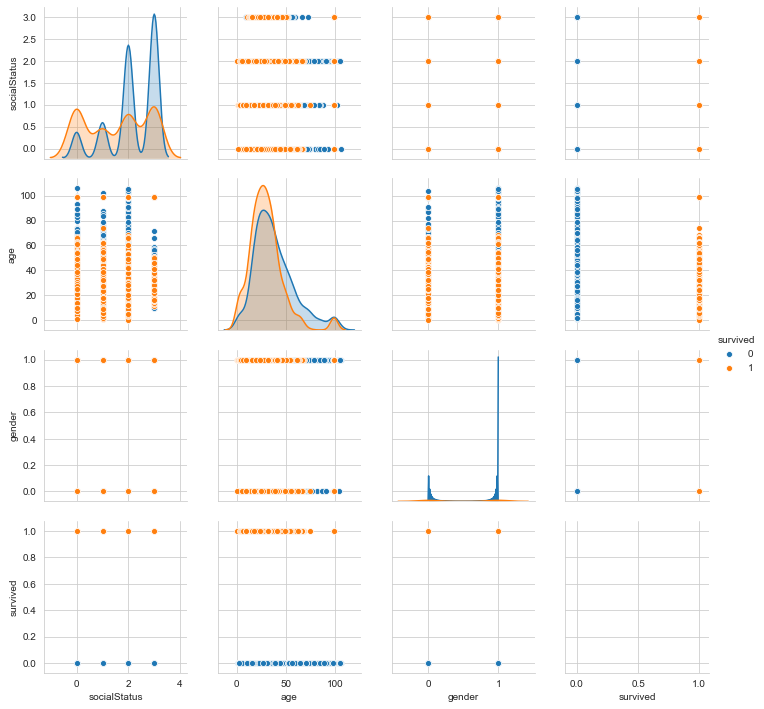

In [22]:
sns.pairplot(
    df_enc[df_enc.notna()],
    hue="survived"
);

**Beschreibung:** PairPlot stellt die einzelnen Features visuell gegenüber.  
**Analyse:**

- socialStatus:
  - erste Klasse hat größere Anzahl Überlebender als Ertrunkener
  - Frauen haben klassenunabhängig ähnliche Chancen
  - Männer haben geringere Chancen mit abnehmender Klasse
- age
  - Ältere Passagiere haben geringere bis keine Chancen
  - Passagiere bis etwa 30 Jahre haben höhere Überlebenschance als Tod
- gender
  - Überwiegend Frauen haben überlebt

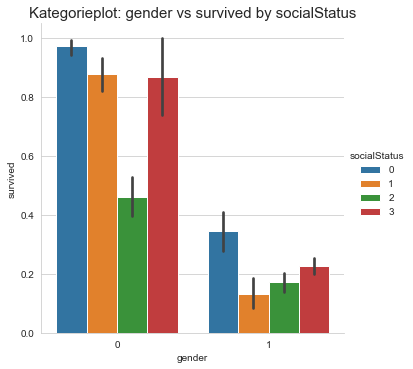

In [23]:
sns.catplot(x="gender", y="survived", hue="socialStatus", kind="bar", data=df_enc);
plt.title("Kategorieplot: gender vs survived by socialStatus", size=15);
plt.show();

In [24]:
print(df_enc[df_enc['gender']==0]['socialStatus'].value_counts())  # female
print("{:.2f}".format(df_enc[df_enc['gender']==0]['survived'].mean()))
print()
print(df_enc[df_enc['gender']==1]['socialStatus'].value_counts())  # male
print("{:.2f}".format(df_enc[df_enc['gender']==1]['survived'].mean()))

2    195
0    144
1    106
3     23
Name: socialStatus, dtype: int64
0.73

3    848
2    507
0    180
1    176
Name: socialStatus, dtype: int64
0.21


**Beschreibung:** CategoricalPLot stellt die Features abh. der Kategorien visuell gegenüber.  
**Analyse: SocialStatus**

- Klassen: ['1st' '2nd' '3rd' 'crew']
- allgemein haben Männer jedes 'socialStatus' geringere Überlebenschancen als Frauen (0.21 vs 0.73)
- 3rd schneidet schlechter ab als Crew (ausgenommen bei Männern)

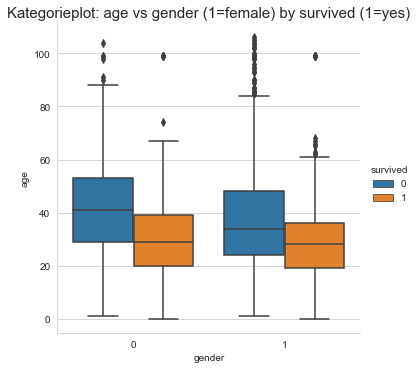

In [25]:
sns.catplot(x="gender", y="age", hue="survived", kind="box", data=df_enc);
plt.title("Kategorieplot: age vs gender (1=female) by survived (1=yes)", size=15);
plt.show();

**Beschreibung:** CategoricalPLot stellt die Features abh. der Kategorien visuell gegenüber.  
**Analyse: age**

- Überlebende sind grundsätzlich jünger, egal ob male/female

In [26]:
df_enc = df_enc[(df_enc['gender'].notna())].copy()
df_enc['gender'] = df_enc['gender'].astype(int)

**Korrelationsplot ('Pearson'):**  
Vorlage: [src](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

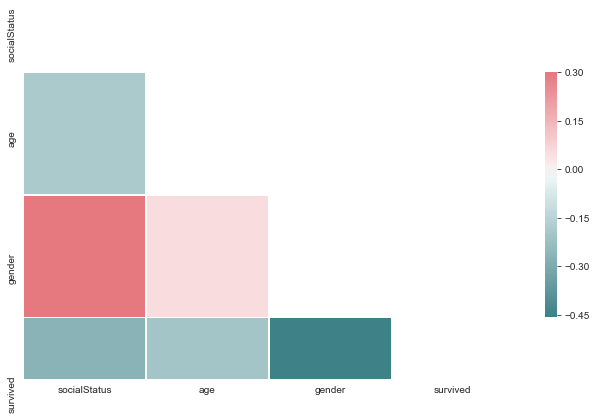

In [27]:
# Compute the correlation matrix
corr = df_enc.corr()  # 'spearman'

# Generate a mask for the upper triangle
mask = pd.np.zeros_like(corr, dtype=pd.np.bool)
mask[pd.np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)
# cmap = sns.choose_diverging_palette(as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, mask=mask, cmap=cmap,
    vmax=.3,
    center=0,
    square=True,
    linewidths=.8,
    cbar_kws={"shrink": .5} # fuer legende
);

In [28]:
df_enc.corr()

socialStatus       age    gender  survived
socialStatus      1.000000 -0.182892  0.377841 -0.268099
age              -0.182892  1.000000  0.053350 -0.199610
gender            0.377841  0.053350  1.000000 -0.456274
survived         -0.268099 -0.199610 -0.456274  1.000000

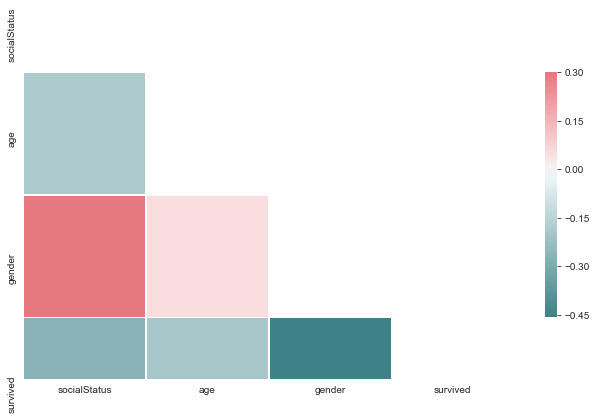

In [29]:
# Compute the correlation matrix
corr = df_enc[(df_enc['age']<100) & (df_enc.T.notna().any())].corr()  # 'spearman'

# Generate a mask for the upper triangle
mask = pd.np.zeros_like(corr, dtype=pd.np.bool)
mask[pd.np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)
# cmap = sns.choose_diverging_palette(as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, mask=mask, cmap=cmap,
    vmax=.3,
    center=0,
    square=True,
    linewidths=.8,
    cbar_kws={"shrink": .5} # fuer legende
);

**Beschreibung:** Korrelations-HeatMap zeigt zusammenhänge an (Pearson-Korr-Koeff)  
**Analyse:** Nur schwache Zusammenhänge erkenntlich; Auch bei age < 100 keine Veränderung ...

**Fazit**:

Auswertung lässt vermuten, dass ein Klassifizierer tendenziell Geschlecht=Frauen, anschließend Alter="jünger" für die Vorhersage "überlebend" bevorzugt.

## Data Preparation

### Select Data

Verwende "X_train" aus Quelldatensatz.

In [30]:
print(X_train.shape)
print(X_train.dtypes)
X_train.head()

(1474, 3)
socialStatus    object
age              int64
gender          object
dtype: object


socialStatus  age  gender
334          crew   41    male
1952          3rd   32  female
2175          3rd   45    male
1247          3rd   15    male
963          crew   48    male

### Clean data

Verwende LabelEncoder für kategorische Variablen.

- Variante 1: keine Zeilen mit NaN, alle mit age < 100
- Variante 2: **tbd**

In [31]:
# combine to align indices
df_train = pd.concat([X_train, y_train], axis=1)
df_train = df_train[
    (df_train['gender'].notna()) & (df_train['age'] < 100)
    ].copy()
df_train.shape

(1450, 4)

In [32]:
for col in ['socialStatus', 'gender', 'survived']:
    df_train[col] = label_encoders[col].transform(df_train[col])

In [33]:
# X_train
X_cols = [col for col in df_train.columns if col != 'survived']
X_train = df_train[X_cols]
y_train = df_train['survived']

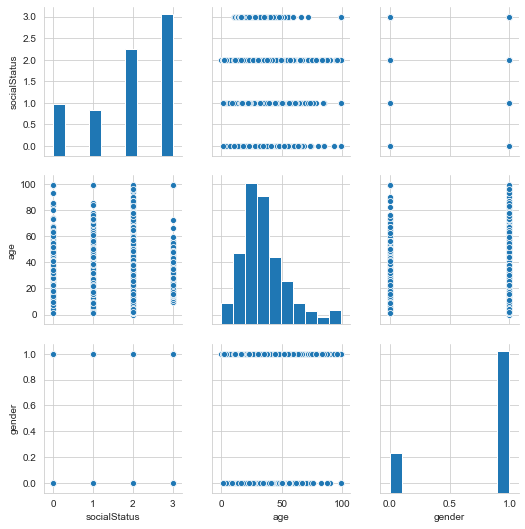

In [34]:
sns.pairplot(X_train);

In [35]:
len(X_test[X_test.isna().T.any()])

5

In [36]:
X_test.shape

(727, 3)

In [37]:
# combine to align indices
df_test = pd.concat([X_test, y_test], axis=1)
df_test = df_test[
    (df_test['gender'].notna()) & (df_test['age'] < 100)
    ].copy()
df_test.shape

(719, 4)

In [38]:
for col in ['socialStatus', 'gender', 'survived']:
    df_test[col] = label_encoders[col].transform(df_test[col])

In [39]:
# X_train
X_cols = [col for col in df_test.columns if col != 'survived']
X_test = df_test[X_cols]
y_test = df_test['survived']

### Construct Data

**Derived Attributes:**

- .

**Generated Records:**

- None

### Integrate Data

...

### Format Data

...

## Modeling


### Select Modeling Techniques

Vorgegebene Modeling Technik: [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) / [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)  

In [40]:
print("Anteil y_test von total: {:.2f}%".format(
    (
        len(y_test) / (
            len(y_train)+len(y_test)
        )
    ) * 100
))

Anteil y_test von total: 33.15%


### Generate Test Design

Vorgebene train/test Datensätze: 1/3

ElasticNet maximiert R-squared, zur Evaluierung soll Accuracy  berechnet werden.

Ablauf:

- training auf "train"
  - Validierung mit CrossValidation (5-split)
- testing mit "test"
  - Test-Metrik: [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
  - Test-set ohne Nan + "age" < 100

In [41]:
X_test.head()

socialStatus  age  gender
780              1   24       0
581              0   18       0
1750             2   99       1
1842             1   45       0
952              2   54       1

In [42]:
y_test.head()

780     1
581     1
1750    0
1842    0
952     0
Name: survived, dtype: int32

In [43]:
len(y_test[(y_test.isna())])

0

### Build Model

#### Datengrundlage / Ansatz

- MVP (minimum viable product)
  - Datenset: variante 1 (keine NaNs, age < 100)
  - Baseline: to beat
- Iteration 1:
  - Datenset: ?

Modelling code in func "basic_training_pipeline" mit 
- [src ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)
- [src GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)
- [src accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)

#### try out ridge and or lasso for each dataset

- l1-ratio: Vorgabe * [0.1, 0.5, 0.9]

(Bowles, 2015, S.132):
```
 The ElasticNet formulation of the penalized regression problem is to use an adjustable blend of the ridge penalty and the Lasso penalty. ElasticNet introduces another parameter, α, that parameterizes the fraction of the total penalty that is the ridge penalty and the fraction that is Lasso penalty. The end pointα=1corresponds to all Lasso penalty and no ridge penalty.  With the ElasticNet formulation, both λ and  α  must be specifi ed to solve for the coeffi cients for a linear model. Usually, the approach is to pick a value for  α and solve for a range of λ′ f s. You’ll see the computational reasons for that later. ′ In many cases, there’s not a big performance difference betweenα=1andα=0 or some intermediate value of  α . Sometimes it will make a big difference, and it behooves you to check to a few different values of  α  to make sure that you’re not sacrifi cing performance needlessly.
```

[LogisticRegression supports ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression)

In [44]:
def basic_training_pipeline(X_train, X_test, y_train, y_test, datasetname):
    
    parameters = {
        'fit_intercept': [True, False],  #
        # 'normalize': [True, False],
        'random_state': [42],
        'multi_class': ['ovr'],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.9],
    }
    # enet = ElasticNet()  # not applicable for classification
    enet = LogisticRegression()
    clf = GridSearchCV(enet, parameters, cv=5)
    clf.fit(X_train, y_train)

    y_pred = (clf.predict(X_test)).astype(int)  # make sure it's an int

    print(datasetname)
    print("train r-squared: {:.3f}".format(
        r2_score(y_train, clf.predict(X_train))
    ))
    print("test r-squared: {:.3f}".format(
        r2_score(y_test, clf.predict(X_test))
    ))
    test_acc = accuracy_score(y_test, y_pred)
    print("test accuracy: {:.2f}\n".format(
        test_acc
    ))
    return test_acc, clf, y_test, y_pred

In [45]:
test_acc, clf, y_test, y_pred = basic_training_pipeline(X_train, X_test, y_train, y_test, "basic - cleaned dataset")

C:\Users\sachs\.conda\envs\datascience\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sachs\.conda\envs\datascience\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sachs\.conda\envs\datascience\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sachs\.conda\envs\datascience\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sachs\.conda\envs\datascience\lib\site-packages\sklearn\linear_model\_sag.py:330: C

### Assess Model


In [46]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(475, 15, 155, 74)

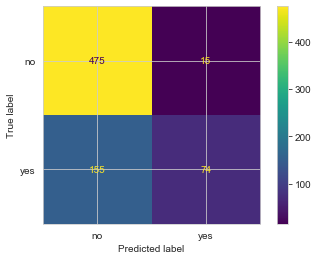

In [47]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), ['no', 'yes']).plot(values_format=".0f");

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_val = auc(fpr, tpr)  # auc: 0.5 == Winkelhalbierende ... bad
auc_val

0.6462659299527671

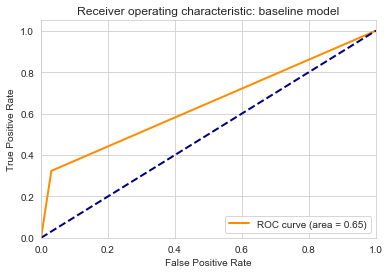

In [49]:
# code from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color='darkorange',
    lw=lw,
    label='ROC curve (area = %0.2f)' % auc_val)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: baseline model')
plt.legend(loc="lower right")
plt.show()

In [50]:
print(clf.best_estimator_)
print()
print(clf.cv_results_['params'][clf.best_index_])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.1, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

{'fit_intercept': True, 'l1_ratio': 0.1, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga'}


#### Model assessment

Model verwendet mit default-Datenset l1_ratio=0.1 (*L2-penalty*)

**Ergebnis**:

- ungenügend: Vorhersage hauptsächlich von Klasse survival: "no"!
  - AUC: 0.65
  - accuracy: 0.76

### Hypothese

finde weitere Verbesserungsmöglichkeit ...

## Evaluate results

### Evaluate results

Die Zielvorgabe von accuracy von 0.95 konnte nicht erreicht werden. Das Model ist somit in der derzeitigen Form nicht verwendbar!  

### Review

Alle Schritte (inkl. feature generation) wurden mit den erlaubten Parametern ausgeführt. Das Endergebnis wurde nicht verfälscht durch ein enkodiertes-NetWeight feature.  
Weitere Schritte siehe "Evaluate Results"

## Deployment

**kein deployment geplant**

Retrainierung des Models auf kompletter Datenbasis.

### angestrebte Architektur

DockerContainer mit RestAPI (fastAPI+guvicorn) mit gepickeltem Model-file. Deployment z.B. in Azure Container Instances, oder Kubernetes Cluster - je nach zu erwartendem traffic ;-) .